# **Uczenie Maszynowe - LAB03 - LIME**

Przygotowali: Arkadiusz Pajor i Michał Sokół

Ten notebook jest wprowadzeniem w zagadnienie Interpretowalnego Uczenia Aktywnego (ang. Interpretable Active Learning).

Slajdy z prezentacji znajdują się w załączonych materiałach.

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [1]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [6]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

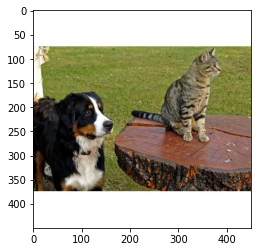

In [7]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [8]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [9]:
inception_v3 = models.inception_v3(pretrained=True)

### **Predykcja**

In [10]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [11]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [12]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [13]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    img_tensor = img_tensor.to(device)
    
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().cpu().numpy()
    top_labels = probas_top[1][0].detach().cpu().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

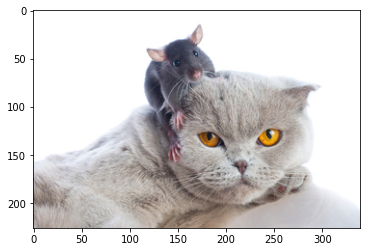

In [14]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

In [15]:
type(exercise_image)

PIL.Image.Image

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [16]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967491
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [17]:
explainer = lime_image.LimeImageExplainer()

In [18]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [19]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

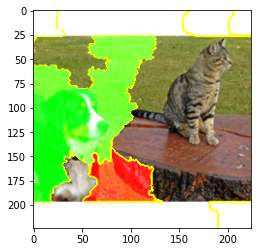

In [20]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

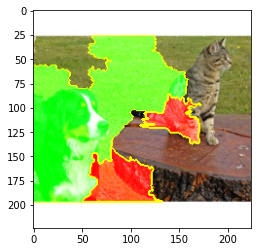

In [20]:
NUM_FEATURES = 10

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**
To fragment obrazka, który łączy piksele za pomocą funkcji podobieństwa.

## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**
Superpiksel może zawierać się w jednym pikselu (choć z reguły tak nie jest), to zależy od funkcji podobieństwa.

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

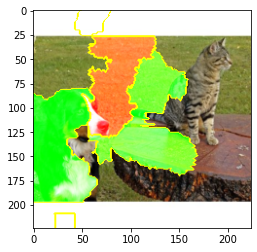

In [21]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

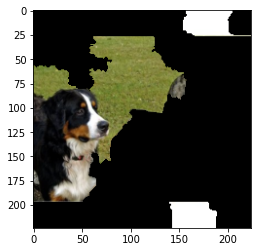

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

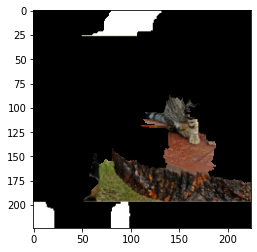

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [24]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)
get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: mortarboard                    | Probability: 0.062673
Class: hummingbird                    | Probability: 0.057413
Class: Irish_water_spaniel            | Probability: 0.053027
Class: African_grey                   | Probability: 0.051829
Class: Afghan_hound                   | Probability: 0.048933
Class: feather_boa                    | Probability: 0.034497
Class: upright                        | Probability: 0.030330
Class: groom                          | Probability: 0.027992
Class: standard_poodle                | Probability: 0.023000
Class: grand_piano                    | Probability: 0.021919
Class: academic_gown                  | Probability: 0.020910
Class: miniature_poodle               | Probability: 0.017112
Class: flat-coated_retriever          | Probability: 0.016526
Class: guillotine                     | Probability: 0.015237
Class: groenendael                    | Probability: 0.015190


I jak go teraz widzi model

In [25]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

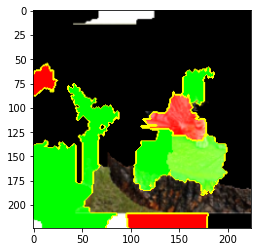

In [26]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [27]:
alexnet = models.alexnet(pretrained=True)

In [28]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

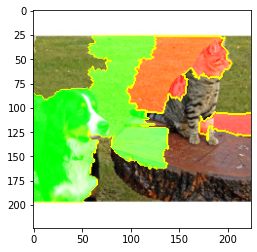

In [30]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [31]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935929
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie amfibii:
![title](data/amfibia.jpg)


In [32]:
amphibious_vehicle = get_image("./data/amfibia.jpg")

  0%|          | 0/500 [00:00<?, ?it/s]

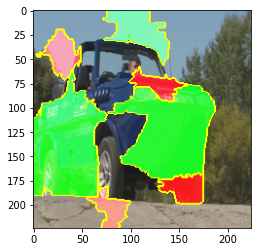

In [33]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=500)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują amfibię jako najbardziej prawdopodobną klasę:

In [34]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

amphibian
convertible
racer
car_wheel
golfcart


# Zadanie domowe #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

## googlenet

In [35]:
googlenet = models.googlenet(pretrained=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

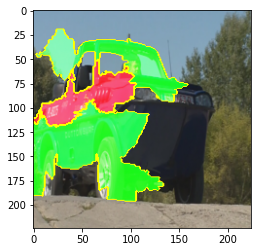

In [36]:
explanation_amhibious_vehicle_google = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, googlenet),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_google.get_image_and_mask(
    label=explanation_amhibious_vehicle_google.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [37]:
for index in explanation_amhibious_vehicle_google.top_labels:
    print(index_to_label[index])

pickup
tow_truck
jeep
amphibian
convertible


Jak widać, googlenet rozpoznaje obrazek jako pickup.

### ResNet18

In [39]:
resnet = models.resnet18(pretrained=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

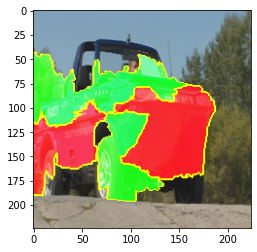

In [40]:
explanation_amhibious_vehicle_resnet = explainer.explain_instance(
    image=lime_transformer(amphibious_vehicle), 
    classifier_fn=partial(predict_batch, resnet),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_resnet.get_image_and_mask(
    label=explanation_amhibious_vehicle_resnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [41]:
for index in explanation_amhibious_vehicle_google.top_labels:
    print(index_to_label[index])

pickup
tow_truck
jeep
amphibian
convertible


Podobnie z resnet18, pierwsza klasa to pickup, ale jak widać, przód pojazdu, typowy dla amfibii negatwynie wpływa na prawdopodonbieństwo klasyfikacji obrazka jako pickup.

# Zadanie domowe #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie była** amfibia a jakiś inny pojazd (np. samochód). W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

W przypadku inception_v3, istotnym elementem dla amfibii jest przód pojazdu. Zakryjmy go i zobaczmy jak będzie wyglądać klasyfikacja!

In [46]:
from PIL import ImageDraw

In [97]:
modified_image = get_image("./data/amfibia.jpg")
drawer = ImageDraw.Draw(modified_image)
drawer.rectangle([(500, 200), (800, 400)], fill ="#000000")

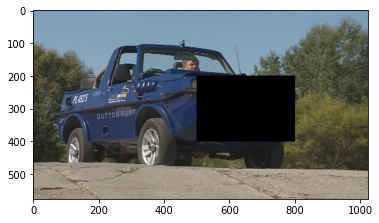

In [98]:
plt.imshow(modified_image)

  0%|          | 0/1000 [00:00<?, ?it/s]

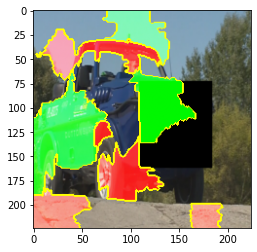

In [100]:
explanation_amhibious_vehicle_inception_v3 = explainer.explain_instance(
    image=lime_transformer(modified_image), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_amhibious_vehicle_inception_v3.get_image_and_mask(
    label=explanation_amhibious_vehicle_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

In [101]:
for index in explanation_amhibious_vehicle_inception_v3.top_labels:
    print(index_to_label[index])

tow_truck
pickup
amphibian
forklift
garbage_truck


Jak widać - najbardziej prawdopodobna klasa się zmieniła i teraz jest to laweta ;)

# Zadanie domowe #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.